In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [4]:
# combine all json file in all-weeks8-9
def slack_parser(path_channel):
    """ parse slack data to extract useful informations from the json file
        step of execution
        1. Import the required modules
        2. read all json file from the provided path
        3. combine all json files in the provided path
        4. extract all required informations from the slack data
        5. convert to dataframe and merge all
        6. reset the index and return dataframe
    """

    # specify path to get json files
    combined = []
    for json_file in glob.glob(f"{path_channel}*.json"):
        with open(json_file, 'r', encoding="utf8") as slack_data:
            data=json.load(slack_data)
            combined.append(data)

    # loop through all json files and extract required informations
    dflist = []
    for slack_data in combined:

        msg_type, msg_content, sender_id, time_msg, msg_dist, time_thread_st, reply_users, \
        reply_count, reply_users_count, tm_thread_end = [],[],[],[],[],[],[],[],[],[]

        for row in slack_data:
            if 'bot_id' in row.keys():
                continue
            else:
                msg_type.append(row['type'])
                msg_content.append(row['text'])
                if 'user_profile' in row.keys(): sender_id.append(row['user_profile']['real_name'])
                else: sender_id.append('Not provided')
                time_msg.append(row['ts'])
                if 'blocks' in row.keys() and row['blocks'] is not None and len(row['blocks'][0]['elements'][0]['elements']) != 0:
                    msg_dist.append(row['blocks'][0]['elements'][0]['elements'][0]['type'])
                else: msg_dist.append('reshared')
                if 'thread_ts' in row.keys():
                    time_thread_st.append(row['thread_ts'])
                else:
                    time_thread_st.append(0)
                if 'reply_users' in row.keys(): reply_users.append(",".join(row['reply_users'])) 
                else:    reply_users.append(0)
                if 'reply_count' in row.keys():
                    reply_count.append(row['reply_count'])
                    reply_users_count.append(row['reply_users_count'])
                    tm_thread_end.append(row['latest_reply'])
                else:
                    reply_count.append(0)
                    reply_users_count.append(0)
                    tm_thread_end.append(0)
        data = zip(msg_type, msg_content, sender_id, time_msg, msg_dist, time_thread_st,
         reply_count, reply_users_count, reply_users, tm_thread_end)
        columns = ['msg_type', 'msg_content', 'sender_name', 'msg_sent_time', 'msg_dist_type',
         'time_thread_start', 'reply_count', 'reply_users_count', 'reply_users', 'tm_thread_end']

        df = pd.DataFrame(data=data, columns=columns)
        df = df[df['sender_name'] != 'Not provided']
        dflist.append(df)

    dfall = pd.concat(dflist, ignore_index=True)
    dfall['channel'] = path_channel.split('/')[-1].split('.')[0]        
    dfall = dfall.reset_index(drop=True)
    
    return dfall

    # return dfall


def parse_slack_reaction(path, channel):
    """get reactions"""
    dfall_reaction = pd.DataFrame()
    combined = []
    for json_file in glob.glob(f"{path}*.json"):
        with open(json_file, 'r') as slack_data:
            data = json.load(slack_data)
            combined.append(data)

    reaction_name, reaction_count, reaction_users, msg, user_id = [], [], [], [], []

    for slack_data in combined:
        # slack_data = json.load(open(k.name, 'r', encoding="utf-8"))

        for i_count, i in enumerate(slack_data):
            if 'reactions' in i.keys():
                for j in range(len(i['reactions'])):
                    msg.append(i['text'])
                    user_id.append(i['user'])
                    reaction_name.append(i['reactions'][j]['name'])
                    reaction_count.append(i['reactions'][j]['count'])
                    reaction_users.append(",".join(i['reactions'][j]['users']))

    data_reaction = zip(reaction_name, reaction_count, reaction_users, msg, user_id)
    columns_reaction = ['reaction_name', 'reaction_count', 'reaction_users_count', 'message', 'user_id']
    df_reaction = pd.DataFrame(data=data_reaction, columns=columns_reaction)
    df_reaction['channel'] = channel
    return df_reaction

def get_community_participation(path):
    """ specify path to get json files"""
    combined = []
    comm_dict = {}
    for json_file in glob.glob(f"{path}*.json"):
        with open(json_file, 'r') as slack_data:
            combined.append(slack_data)
    # print(f"Total json files is {len(combined)}")
    for i in combined:
        a = json.load(open(i.name, 'r', encoding='utf-8'))

        for msg in a:
            if 'replies' in msg.keys():
                for i in msg['replies']:
                    comm_dict[i['user']] = comm_dict.get(i['user'], 0)+1
    return comm_dict

In [5]:
def convert_2_timestamp(column, data):
    """convert from unix time to readable timestamp
        args: column: columns that needs to be converted to timestamp
                data: data that has the specified column
    """
    if column in data.columns.values:
        timestamp_ = []
        for time_unix in data[column]:
            if time_unix == 0:
                timestamp_.append(0)
            else:
                a = datetime.datetime.fromtimestamp(float(time_unix))
                timestamp_.append(a.strftime('%Y-%m-%d %H:%M:%S'))
        return timestamp_
    else:
        print(f"{column} not in data")

def get_tagged_users(df):
    """get all @ in the messages"""

    return df['msg_content'].map(lambda x: re.findall(r'@U\w+', x))



def map_userid_2_realname(user_profile: dict, comm_dict: dict, plot=False):
    """
    map slack_id to realnames
    user_profile: a dictionary that contains users info such as real_names
    comm_dict: a dictionary that contains slack_id and total_message sent by that slack_id
    """
    user_dict = {} # to store the id
    real_name = [] # to store the real name
    ac_comm_dict = {} # to store the mapping
    count = 0
    # collect all the real names
    for i in range(len(user_profile['profile'])):
        real_name.append(dict(user_profile['profile'])[i]['real_name'])

    # loop the slack ids
    for i in user_profile['id']:
        user_dict[i] = real_name[count]
        count += 1

    # to store mapping
    for i in comm_dict:
        if i in user_dict:
            ac_comm_dict[user_dict[i]] = comm_dict[i]

    ac_comm_dict = pd.DataFrame(data= zip(ac_comm_dict.keys(), ac_comm_dict.values()),
    columns=['LearnerName', '# of Msg sent in Threads']).sort_values(by='# of Msg sent in Threads', ascending=False)

    if plot:
        ac_comm_dict.plot.bar(figsize=(15, 7.5), x='LearnerName', y='# of Msg sent in Threads')
        plt.title('Student based on Message sent in thread', size=20)

    return ac_comm_dict

In [47]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()
def get_bottom_10_user(data,channel):
    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()
    
def get_bottom_10_user_reaction(data,channel):
    data['user_id'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()
    

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def plot_common_words(json_file_path, channel_name):
    # Read the JSON file
    with open(json_file_path, 'r', encoding="utf8") as json_file:
        data = json.load(json_file)

    # Convert the data to a DataFrame (adjust as per your JSON structure)
    df = pd.DataFrame(data)

    # Filter messages for the specified channel
    channel_data = df[df['channel'] == channel_name]

    # Combine the text of messages in the channel
    all_text = ' '.join([str(msg.get('text', '')) for msg in channel_data['topic']])

    # Split the text into words
    words = all_text.split()

    # Create a pandas Series for easy word counting
    word_counts = pd.Series(words).value_counts()

    # Plot the top N words
    top_n = 20  # Change this value to adjust the number of words to display
    plt.figure(figsize=(12, 6))
    word_counts.head(top_n).plot(kind='bar', color='skyblue')
    plt.title(f'Top {top_n} Words in #{channel_name}')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.show()

#plot of top users with highest replies per message.
def plot_visualize_top_10_users_with_highest_reply_count(data: pd.DataFrame):
    grouped_df = data.groupby('sender_name')['reply_count'].sum()
    grouped_df = grouped_df.sort_values(ascending=False)
    grouped_df.plot(kind='bar', figsize=(15, 7.5))
    plt.yscale('log')
    plt.title('Reply Counts of users')
    plt.xlabel('User')
    plt.ylabel('Number of Replies')
    plt.show()

## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

In [7]:
def create_dataframe() -> pd.DataFrame:
    DIR = '../anonymized/'
    sl = SlackDataLoader(DIR)
    data_frames = [
        slack_parser(DIR + channel['name'] + '/')
        for channel in sl.get_channels()
    ]
    all_data = pd.concat(data_frames, ignore_index=True)
    return all_data

In [8]:
dframe = create_dataframe()
dframe

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel
0,message,"a decent fellow, big ups brother",Gregory Bowman,1664960833.241189,text,1664954598.185699,0,0,0,0,
1,message,*community building session reminder!*:timer_c...,Lynn Shepherd,1664970601.066509,text,0,0,0,0,0,
2,message,when will we kahoot again:smirk:,Jennifer Carrillo,1664970669.636589,text,1664970669.636589,2,2,"U03V1AM5TFA,U03U1FNPEUX",1664970735.145469,
3,message,"soon very soon, you miss it hahahah",Lynn Shepherd,1664970705.135159,text,1664970669.636589,0,0,0,0,
4,message,yess,Jennifer Carrillo,1664970735.145469,text,1664970669.636589,0,0,0,0,
...,...,...,...,...,...,...,...,...,...,...,...
17744,message,how are we going to do the submission today? e...,Monica Newton,1667831518.280939,text,1667831518.280939,1,1,U03TEPYRM2P,1667831802.415459,
17745,message,thank you,Bridget Glover,1667831802.415459,text,1667831518.280939,0,0,0,0,
17746,message,"the document is not uploaded yet, and what is ...",Lisa Dickerson,1667833875.288709,text,1667833875.288709,2,1,U03UP7V9Q57,1667835382.576969,
17747,message,how can i get the trainees that opted-in a giv...,Dennis Parker,1668272023.894179,text,0,0,0,0,0,


In [44]:
# plot users from top to bottom based on replay count
def plot_highest_replies_per_user(data: pd.DataFrame):
    grouped_df = data.groupby('sender_name')['reply_count'].sum()
    grouped_df = grouped_df.sort_values(ascending=False)
    grouped_df.plot(kind='bar', figsize=(15, 7.5))
    plt.yscale('log')
    plt.title('Reply Counts of users')
    plt.xlabel('User')
    plt.ylabel('Number of replies')
    plt.show()


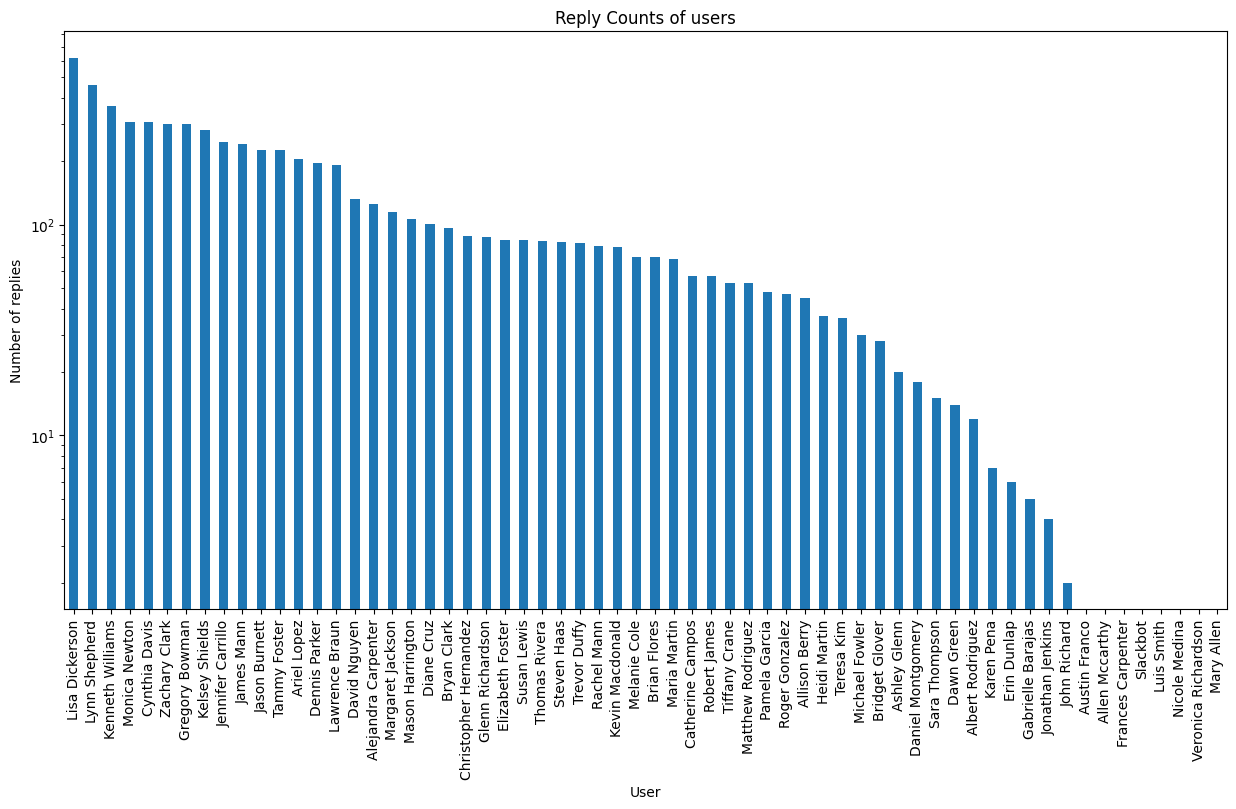

In [45]:
plot_highest_replies_per_user(dframe)

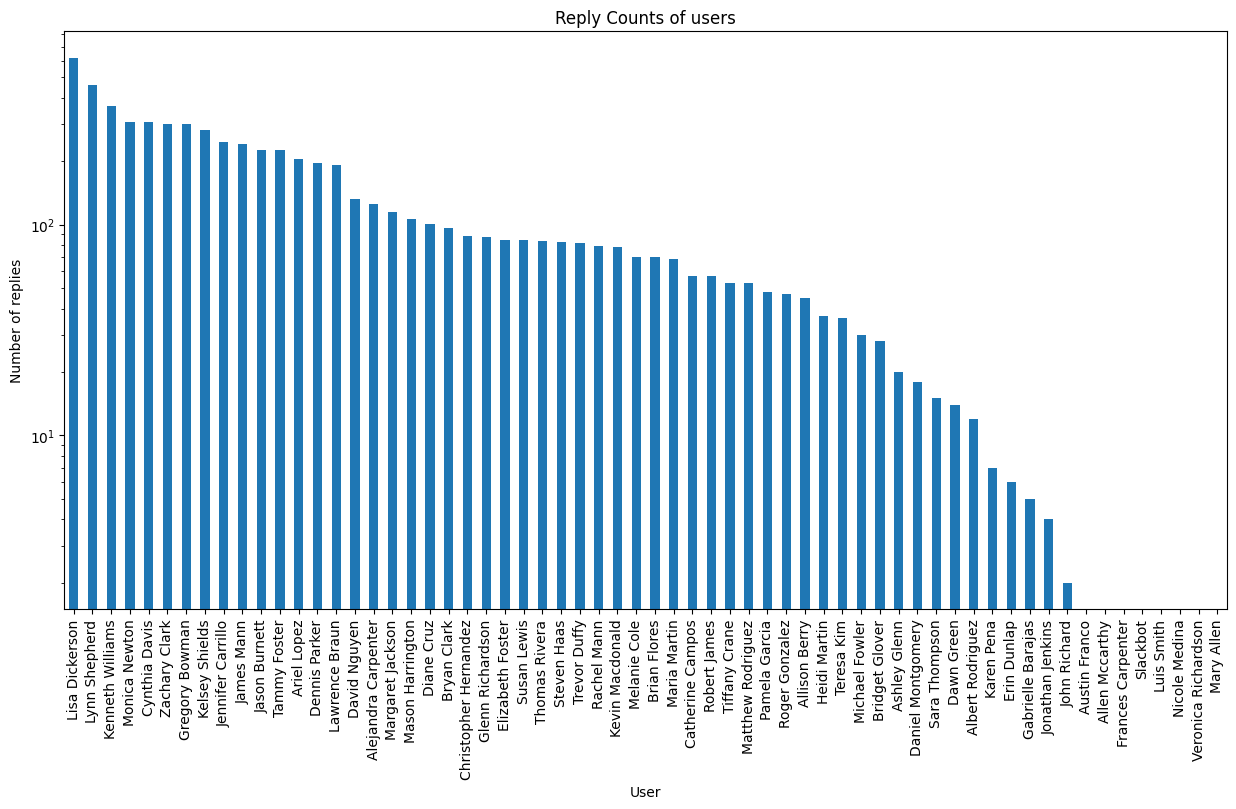

In [48]:
# Top 10 users with highest reply count
plot_visualize_top_10_users_with_highest_reply_count(dframe)

In [49]:
def get_top_users_by_replies_count(data: pd.DataFrame, top_n=10):
    top_users = data.nlargest(top_n, 'reply_count')[['sender_name', 'reply_count']]
    return top_users

In [50]:
#display users with highest replies
get_top_users_by_replies_count(dframe)

,sender_name,reply_count
7208,Kenneth Williams,75
975,Kevin Macdonald,63
15078,James Mann,61
1546,Kenneth Williams,57
10053,Bryan Clark,54
11662,Lynn Shepherd,45
16495,Jason Burnett,44
10141,Zachary Clark,36
11757,Lynn Shepherd,33
6843,Kenneth Williams,31


In [51]:
def get_bottom_users_by_replies_count(data: pd.DataFrame, bottom_n=10):
    bottom_users = data.nsmallest(bottom_n, 'reply_count')[['sender_name', 'reply_count']]
    return bottom_users

In [52]:
get_bottom_users_by_replies_count(dframe)

,sender_name,reply_count
0,Gregory Bowman,0
1,Lynn Shepherd,0
3,Lynn Shepherd,0
4,Jennifer Carrillo,0
6,Monica Newton,0
7,Daniel Montgomery,0
8,Trevor Duffy,0
9,Kenneth Williams,0
10,Thomas Rivera,0
11,Zachary Clark,0


In [42]:
#plot for top 10 users with reply count
def plot_top_users_with_highest_replies(data: pd.DataFrame, top_n=10):
    top_users = get_top_users_by_replies_count(data, top_n)

    plt.figure(figsize=(16, 8))
    plt.bar(top_users['sender_name'], top_users['reply_count'], color='pink')
    plt.yscale('log')
    plt.title(f'Top {top_n} Users with the Highest Replies')
    plt.xlabel('User')
    plt.ylabel('Number of Replies')
    plt.show()

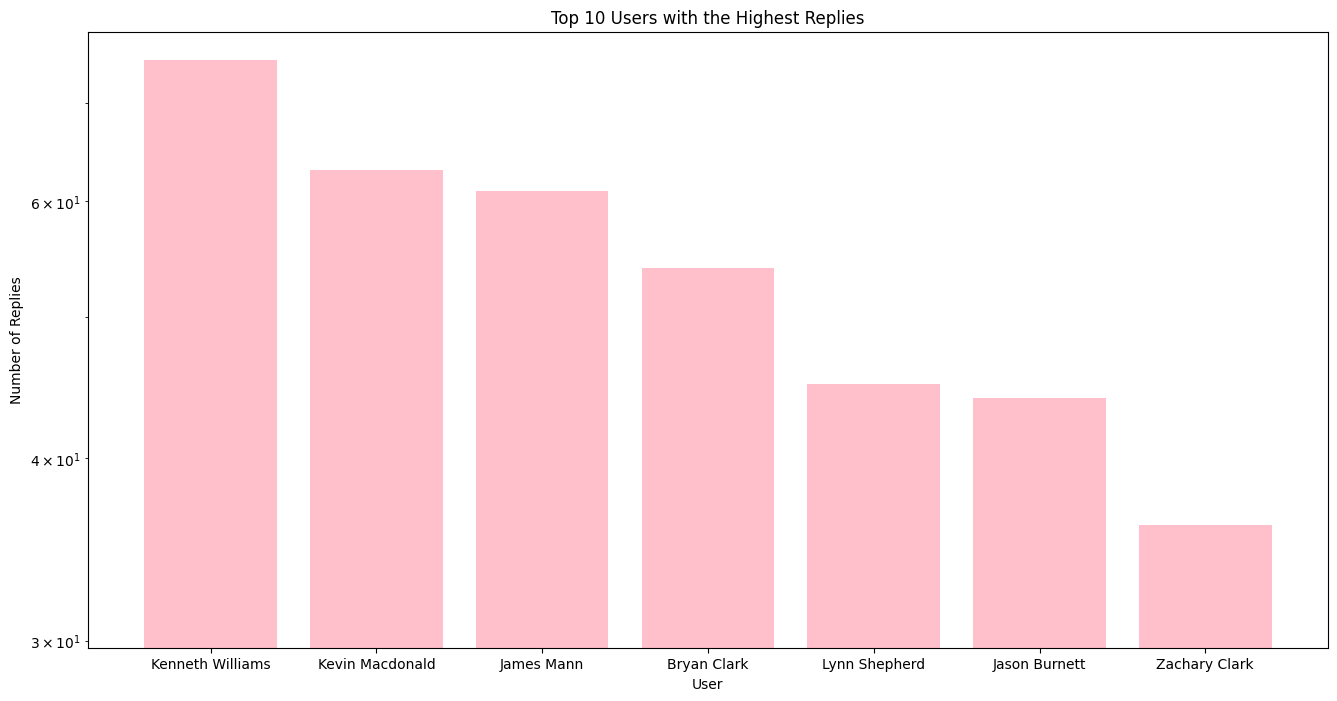

In [43]:
plot_top_users_with_highest_replies(dframe)

In [40]:
def plot_top_users_with_lowest_replies(data: pd.DataFrame, top_n=10):
    bottom_users = get_bottom_users_by_replies_count(data, top_n)

    plt.figure(figsize=(12, 6))
    plt.scatter(bottom_users['sender_name'], bottom_users['reply_count'], color='pink', s=100)
    plt.title(f'Top {top_n} Users with the Lowest Replies (Logarithmic Scale)')
    plt.xlabel('User')
    plt.ylabel('Number of Replies (Log Scale)')
    plt.xticks(rotation=45, ha='right')
    plt.show()

def get_bottom_users_by_replies_count(data: pd.DataFrame, top_n=10):
    return data.nsmallest(top_n, 'reply_count')[['sender_name', 'reply_count']]

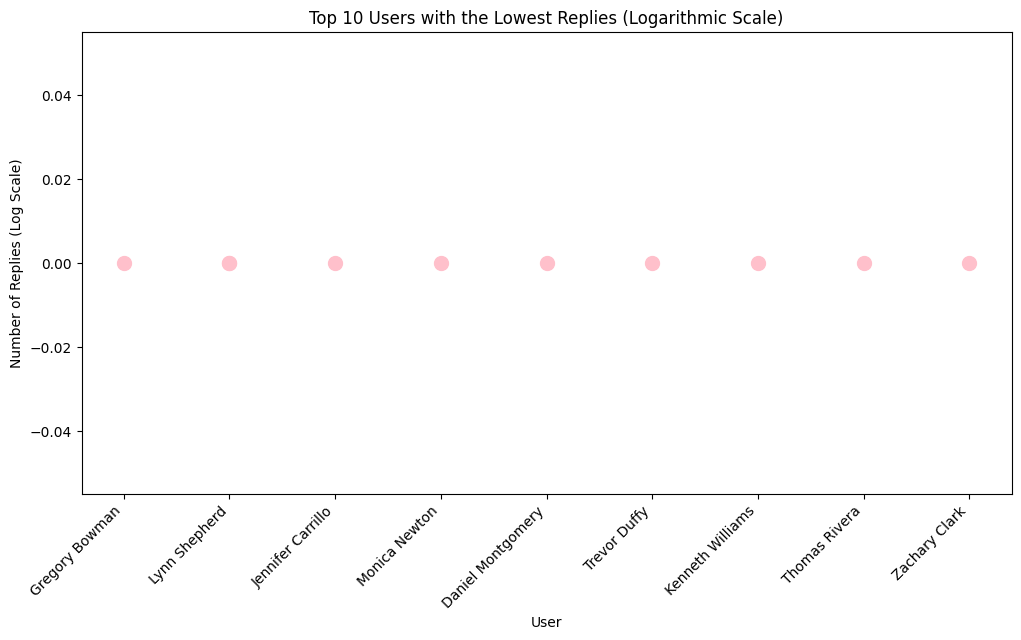

In [41]:
plot_top_users_with_lowest_replies(dframe)